In [ ]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

In [ ]:
# Ruta donde se encuentra el archivo descargado desde Kaggle
zip_file = '/content/brain_tumor_dataset.zip'

# Directorio de extracción
extract_dir = '/content/Dataset'

# Extraer el archivo zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Carpeta donde se encuentran las imágenes
dataset_dir = os.path.join(extract_dir, 'brain_tumor_dataset')

In [ ]:
# Función para cargar las imágenes y etiquetas desde el dataset
def cargar_datos(dataset_dir):
    imagenes = []
    etiquetas = []
    for label in ['no', 'yes']:
        folder_path = os.path.join(dataset_dir, label)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Cargar la imagen en escala de grises
            image = cv2.resize(image, (128, 128))  # Redimensionar todas las imágenes a 128x128 píxeles
            imagenes.append(image)
            etiquetas.append(0 if label == 'no' else 1)

    return np.array(imagenes), np.array(etiquetas)

# Cargar imágenes y etiquetas
imagenes, etiquetas = cargar_datos(dataset_dir)

# Convertir etiquetas a formato categórico
etiquetas_categoricas = to_categorical(etiquetas)


In [ ]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_categoricas, test_size=0.2, random_state=42)

# Normalizar los datos de las imágenes
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Asegurarse de que las dimensiones de las imágenes sean adecuadas para TensorFlow (N, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
# Verificar las dimensiones de los conjuntos de datos
print(f'Dimensiones de X_train: {X_train.shape}')
print(f'Dimensiones de X_test: {X_test.shape}')
print(f'Dimensiones de y_train: {y_train.shape}')
print(f'Dimensiones de y_test: {y_test.shape}')

Dimensiones de X_train: (202, 128, 128, 1)
Dimensiones de X_test: (51, 128, 128, 1)
Dimensiones de y_train: (202, 2)
Dimensiones de y_test: (51, 2)


In [ ]:
# Definir el modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
# Evaluar el modelo con los datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida en los datos de prueba: {loss:.4f}')
print(f'Exactitud en los datos de prueba: {accuracy:.4f}')

2/2 [==============================] - 0s 144ms/step - loss: 0.5932 - accuracy: 0.7451
Pérdida en los datos de prueba: 0.5932
Exactitud en los datos de prueba: 0.7451


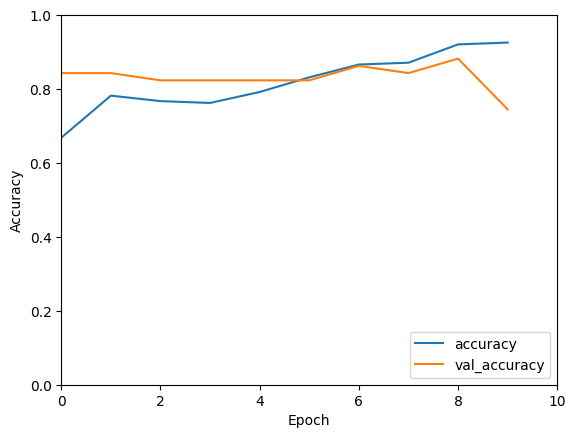

In [ ]:
# Plot with the difference in accuracy values from training and validation.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, 10])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Predicciones
predictions = model.predict(X_test)

# Definir nombres de las clases
class_names = ['No Tumor', 'Tumor']

2/2 [==============================] - 0s 156ms/step


In [ ]:
# Funciones de visualización
def plot_image(i, predictions_array, true_label, img):
    true_label, img = np.argmax(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.squeeze(), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = np.argmax(true_label[i])
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

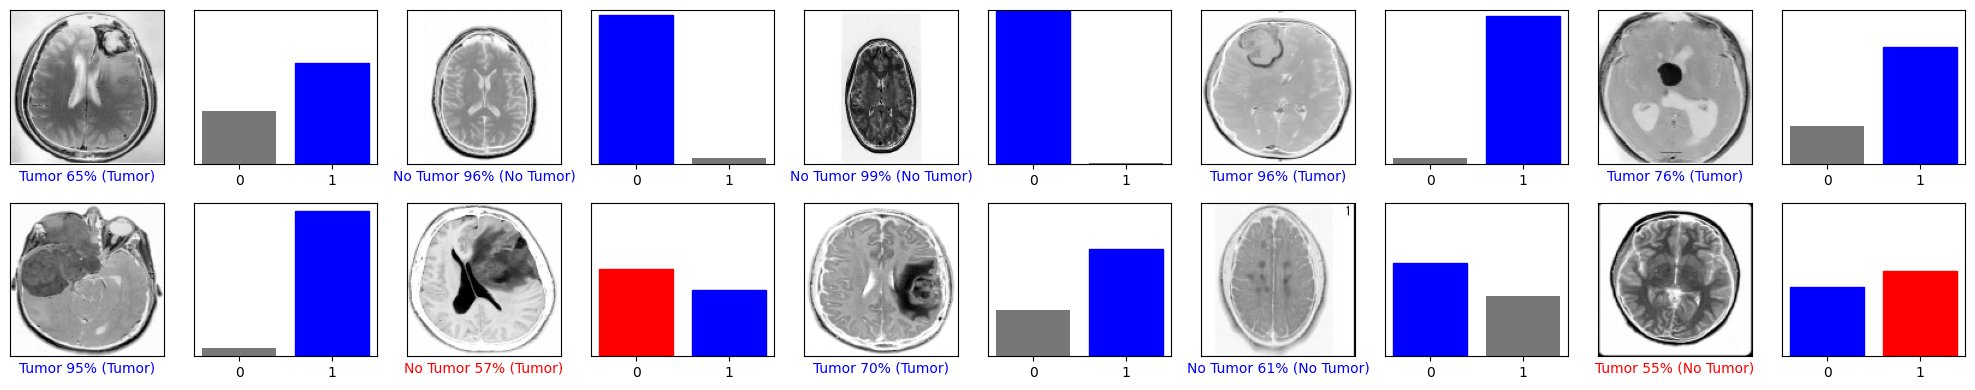

In [ ]:
# Visualizar las predicciones
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()